In [40]:
import os
import gc
import copy
import time
import random

# For data manipulation
import numpy as np
import pandas as pd

# Pytorch Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.cuda import amp

# Utils
import joblib
from tqdm import tqdm
from collections import defaultdict

# Sklearn Imports
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold, KFold

import time

# Albumentations for augmentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

# For colored terminal text
from colorama import Fore, Back, Style
c_ = Fore.CYAN
sr_ = Style.RESET_ALL

import warnings
warnings.filterwarnings("ignore")

# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [41]:
import pandas as pd
import numpy as np
import tensorflow as tf
# import tensorflow_addons as tfa
import glob, warnings
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

warnings.filterwarnings('ignore')
print('TensorFlow Version ' + tf.__version__)

TensorFlow Version 2.17.0


In [42]:
import seaborn as sns
import matplotlib.pyplot as plt
######
import os
import os.path
from pathlib import Path
#import pydicom
import glob
######
from PIL import Image
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
######
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras import regularizers
######
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, roc_curve
######
from tensorflow.keras.optimizers import RMSprop,Adam,Optimizer
######
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization,MaxPooling2D
from tensorflow.keras.layers import BatchNormalization,Permute, TimeDistributed, Bidirectional,GRU, SimpleRNN, LSTM, GlobalAveragePooling2D
from tensorflow.keras import models
from tensorflow.keras import layers
import tensorflow as tf

######
from warnings import filterwarnings

filterwarnings("ignore",category=DeprecationWarning)
filterwarnings("ignore", category=FutureWarning) 
filterwarnings("ignore", category=UserWarning)

In [43]:
###########################################################
#### Setting the path and Reading the data
###################################################
train = pd.read_csv("data/stage_2_train.csv")
sub = pd.read_csv("data/stage_2_sample_submission.csv")
train_images = os.listdir("data/stage_2_train/")
test_images = os.listdir("data/stage_2_test/")
print ('Train:', train.shape[0])
print ('Sub:', sub.shape[0])
print ('Train Images:', len(train_images))
print ('Test Images:', len(test_images))

Train: 4516842
Sub: 727392
Train Images: 752803
Test Images: 121232


In [44]:
###########################################################
#### Getting training and testing data
###################################################
train['type'] = train['ID'].str.split("_", n = 3, expand = True)[2]
train['PatientID'] = train['ID'].str.split("_", n = 3, expand = True)[1]
train['filename'] = train['ID'].apply(lambda st: "ID_" + st.split('_')[1] + ".png")
# Remove invalid PNGs
train=train.head(150000)

sub['filename'] = sub['ID'].apply(lambda st: "ID_" + st.split('_')[1] + ".png")
sub['type'] = sub['ID'].apply(lambda st: st.split('_')[2])
sub=sub.head(150000)
train.head()

,ID,Label,type,PatientID,filename
0,ID_12cadc6af_epidural,0,epidural,12cadc6af,ID_12cadc6af.png
1,ID_12cadc6af_intraparenchymal,0,intraparenchymal,12cadc6af,ID_12cadc6af.png
2,ID_12cadc6af_intraventricular,0,intraventricular,12cadc6af,ID_12cadc6af.png
3,ID_12cadc6af_subarachnoid,0,subarachnoid,12cadc6af,ID_12cadc6af.png
4,ID_12cadc6af_subdural,0,subdural,12cadc6af,ID_12cadc6af.png


In [45]:
###########################################################
#### Understanding the unique types of brain hemmorhage
###################################################
print ('Train type =', list(train.type.unique()))
print ('Train label =', list(train.Label.unique()))

Train type = ['epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural', 'any']
Train label = [0, 1]


In [46]:
###########################################################
#### No of unique type of patients for each of the category
##########################################################
print ('Number of Patients: ', train.PatientID.nunique())

Number of Patients:  24999


In [47]:
###########################################################
#### No of unique type of patients for each of the category
##########################################################
train.type.value_counts()

type
epidural            25000
intraparenchymal    25000
intraventricular    25000
subarachnoid        25000
subdural            25000
any                 25000
Name: count, dtype: int64

Label
0    141404
1      8596
Name: count, dtype: int64


<Axes: xlabel='Label', ylabel='count'>

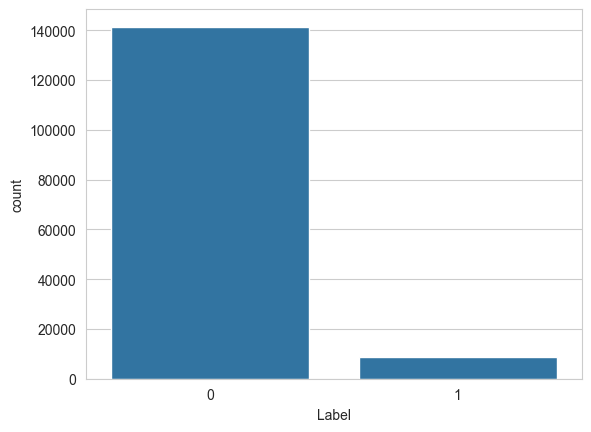

In [48]:
#############################################################
#### Images with label of 0 and 1 such as hammerhoage or not
#############################################################
print(train.Label.value_counts())
sns.countplot(x='Label', data=train)

In [49]:
#######################################################################################
#### Understanding the no of unique type of patients for each of the category in 0 and 1
######################################################################################
train.groupby('type').Label.value_counts()

type              Label
any               0        21382
                  1         3618
epidural          0        24884
                  1          116
intraparenchymal  0        23764
                  1         1236
intraventricular  0        24137
                  1          863
subarachnoid      0        23818
                  1         1182
subdural          0        23419
                  1         1581
Name: count, dtype: int64

<Axes: xlabel='Label', ylabel='count'>

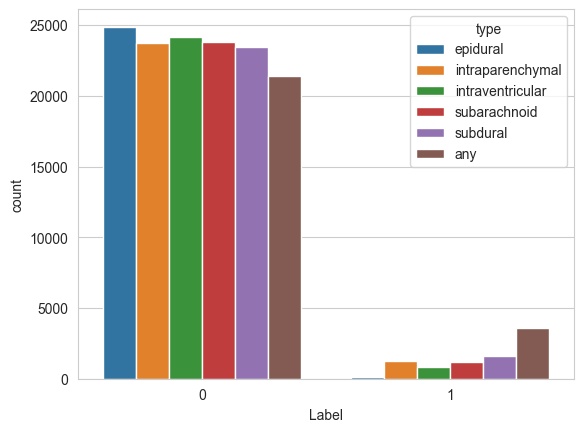

In [50]:
#######################################################################################
#### Understanding the no of unique type of patients for each of the category in 0 and 1
#### in terms of barplot
#####################################################################################

sns.countplot(x="Label", hue="type", data=train)

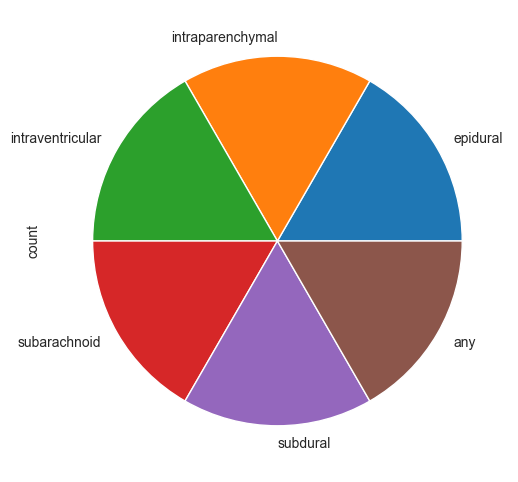

In [51]:
#######################################################################################
#### Understanding the no of unique type of patients for each of the category in 0 and 1
#### in terms of Pie-plot
######################################################################################
train.type.value_counts().plot.pie(figsize=(6,6))
plt.show()

In [52]:
#######################################################################################
#### Here, we are setting the image' windows (3types), ROI and skull removal  
######################################################################################
TRAIN_IMG_PATH = "data/stage_2_train/"
TEST_IMG_PATH = "data/stage_2_test/"
BASE_PATH = 'data/'
TRAIN_DIR = 'stage_2_train/'
TEST_DIR = 'stage_2_test/'

def window_image(img, window_center,window_width, intercept, slope, rescale=True):

    img = (img*slope +intercept)
    img_min = window_center - window_width//2
    img_max = window_center + window_width//2
    img[img<img_min] = img_min
    img[img>img_max] = img_max
    
    if rescale:
        # Extra rescaling to 0-1, not in the original notebook
        img = (img - img_min) / (img_max - img_min)
    
    return img
    
def get_first_of_dicom_field_as_int(x):
    #get x[0] as in int is x is a 'pydicom.multival.MultiValue', otherwise get int(x)
    if type(x) == pydicom.multival.MultiValue:
        return int(x[0])
    else:
        return int(x)

def get_windowing(data):
    dicom_fields = [data[('0028','1050')].value, #window center
                    data[('0028','1051')].value, #window width
                    data[('0028','1052')].value, #intercept
                    data[('0028','1053')].value] #slope
    return [get_first_of_dicom_field_as_int(x) for x in dicom_fields]

    
    
def view_images(images, title = '', aug = None):
    width = 5
    height = 2
    fig, axs = plt.subplots(height, width, figsize=(15,5))
    
    for im in range(0, height * width):
        data = pydicom.dcmread(os.path.join(TRAIN_IMG_PATH,'ID_'+images[im]+ '.dcm'))
        image = data.pixel_array
        window_center , window_width, intercept, slope = get_windowing(data)
        image_windowed = window_image(image, window_center, window_width, intercept, slope)


        i = im // width
        j = im % width
        axs[i,j].imshow(image_windowed, cmap=plt.cm.bone) 
        axs[i,j].axis('off')
        
    plt.suptitle(title)
    plt.show()

data Dataset.file_meta -------------------------------
(0002,0000) File Meta Information Group Length  UL: 188
(0002,0001) File Meta Information Version       OB: b'\x00\x01'
(0002,0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002,0003) Media Storage SOP Instance UID      UI: 1.2.840.4267.32.329990312149826883806689795612780731074
(0002,0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002,0012) Implementation Class UID            UI: 1.2.40.0.13.1.1.1
(0002,0013) Implementation Version Name         SH: 'dcm4che-1.4.35'
-------------------------------------------------
(0008,0018) SOP Instance UID                    UI: ID_000178e76
(0008,0060) Modality                            CS: 'CT'
(0010,0020) Patient ID                          LO: 'ID_462abff7'
(0020,000D) Study Instance UID                  UI: ID_4fef99f0df
(0020,000E) Series Instance UID                 UI: ID_72952d87fa
(0020,0010) Study ID                            SH: ''
(0020,

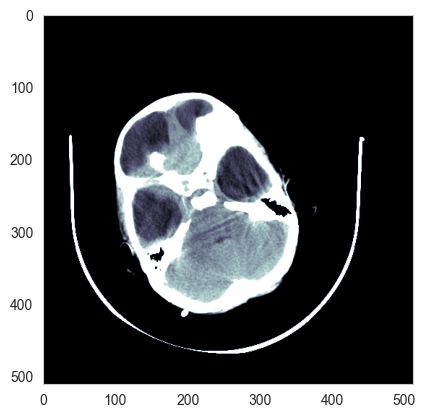

In [53]:
#######################################################################################
#### Demonstration of single image and its complete meta-data information
######################################################################################
import pydicom
case = 8
data = pydicom.dcmread(TRAIN_IMG_PATH+train_images[case])

print("data",data)
window_center , window_width, intercept, slope = get_windowing(data)


#displaying the image
img = pydicom.dcmread(TRAIN_IMG_PATH+train_images[case]).pixel_array

img = window_image(img, window_center, window_width, intercept, slope)
plt.imshow(img, cmap=plt.cm.bone)
plt.grid(False)

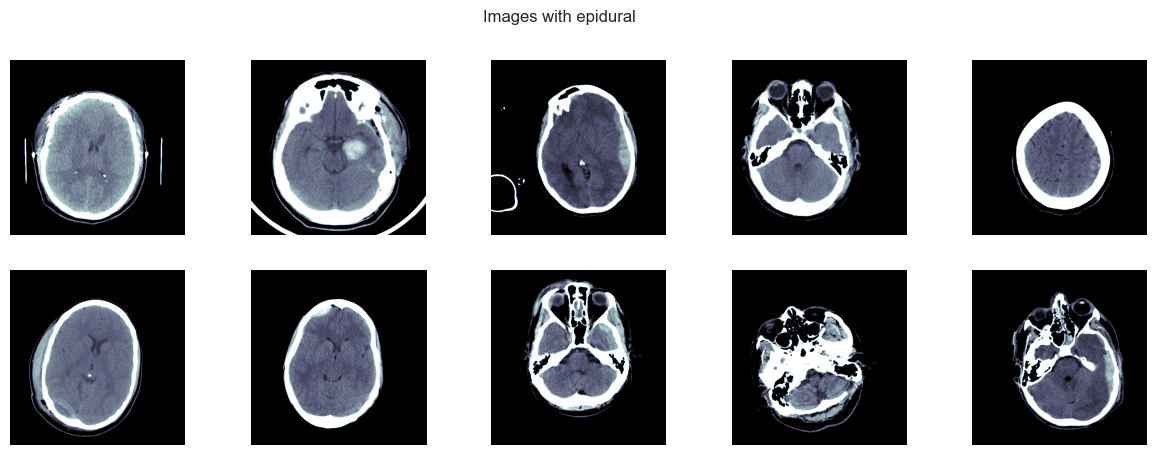

In [54]:
#######################################################################################
#### Demonstration of some epidural images with label 1
######################################################################################

view_images(train[(train['type'] == 'epidural') & (train['Label'] == 1)][:10].PatientID.values, title = 'Images with epidural')

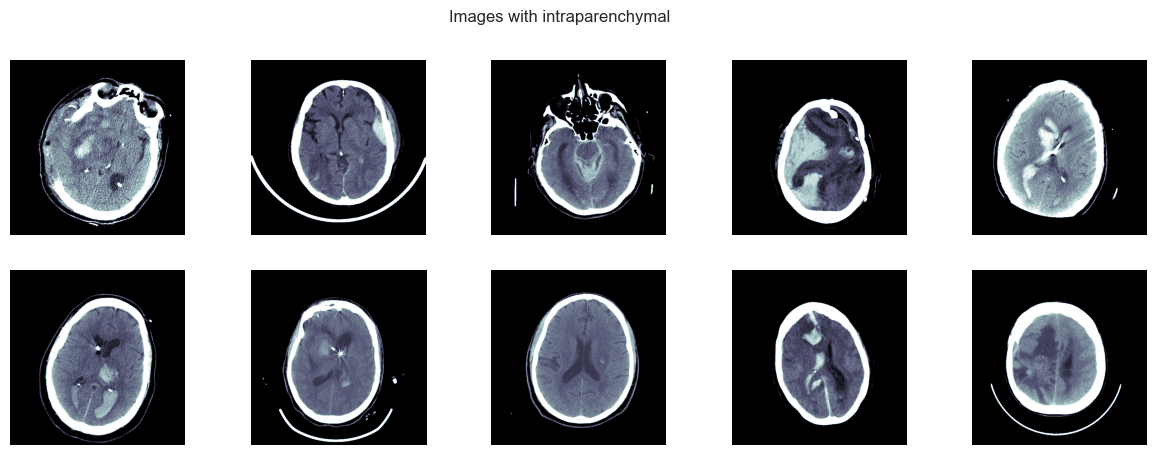

In [55]:
#######################################################################################
#### Demonstration of some intraparenchymal images with label 1
######################################################################################
view_images(train[(train['type'] == 'intraparenchymal') & (train['Label'] == 1)][:10].PatientID.values, title = 'Images with intraparenchymal')

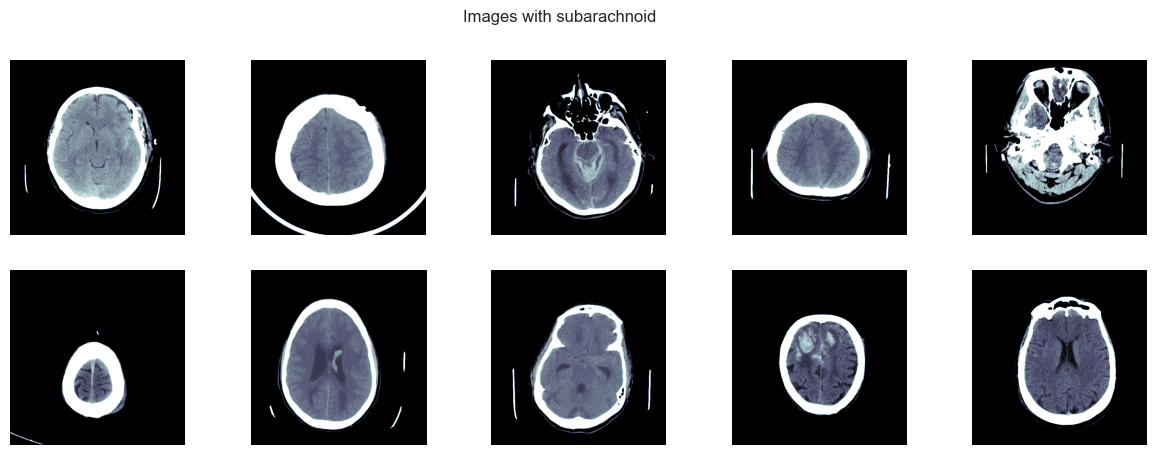

In [56]:
#######################################################################################
#### Demonstration of some subarachnoid images with label 1
######################################################################################
view_images(train[(train['type'] == 'subarachnoid') & (train['Label'] == 1)][:10].PatientID.values, title = 'Images with subarachnoid')

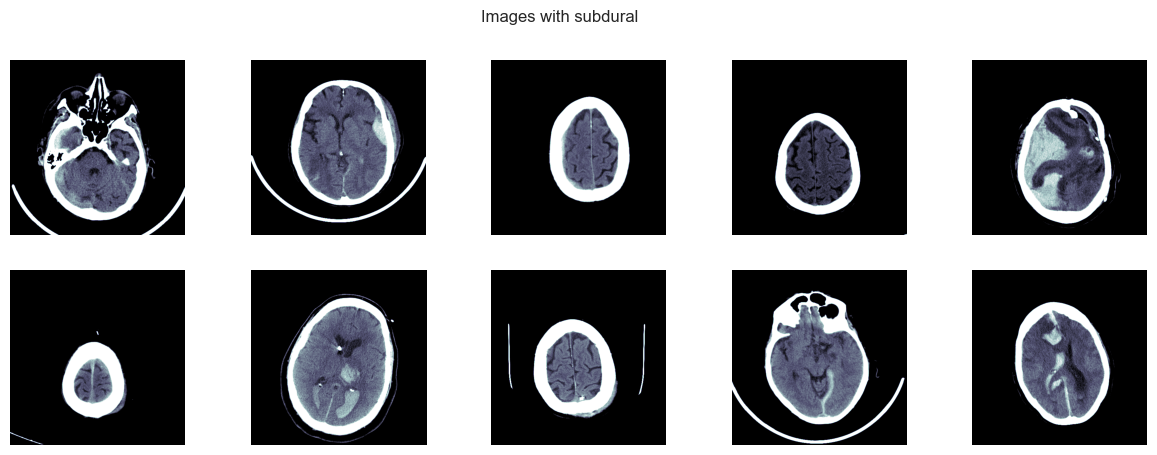

In [57]:
#######################################################################################
#### Demonstration of some subdural images with label 1
######################################################################################
view_images(train[(train['type'] == 'subdural') & (train['Label'] == 1)][:10].PatientID.values, title = 'Images with subdural')

In [58]:
#######################################################################################
#### Setting and demonstration of testing data
######################################################################################

test = pd.DataFrame(sub.filename.unique(), columns=['filename'])
print ('Test:', test.shape[0])
test.head()

Test: 25000


,filename
0,ID_0fbf6a978.png
1,ID_d62ec3412.png
2,ID_cb544194b.png
3,ID_0d62513ec.png
4,ID_fc45b2151.png


In [59]:
#########################################################################################################
#### Getting some random images for training and testing to reduce the computational complexity
########################################################################################################
np.random.seed(1234)
sample_files = np.random.choice(os.listdir(TRAIN_IMG_PATH), 150000)
sample_df = train[train.filename.apply(lambda x: x.replace('.png', '.dcm')).isin(sample_files)]
print(sample_df.shape)

pivot_df = sample_df[['Label', 'filename', 'type']].drop_duplicates().pivot(
    index='filename', columns='type', values='Label').reset_index()
print(pivot_df.shape)
pivot_df.head()

(27558, 5)
(4593, 7)


type,filename,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
0,ID_0005de569.png,0,0,0,0,0,0
1,ID_000854890.png,0,0,0,0,0,0
2,ID_0009c4591.png,0,0,0,0,0,0
3,ID_002ac5a6c.png,0,0,0,0,0,0
4,ID_003d36e87.png,0,0,0,0,0,0


In [60]:
#########################################################################################################
#### Getting some random images for training and testing to reduce the computational complexity
########################################################################################################
np.random.seed(1234)
sample_files_test = np.random.choice(os.listdir(TEST_IMG_PATH), 150000)
sample_files_test_df = sub[sub.filename.apply(lambda x: x.replace('.png', '.dcm')).isin(sample_files_test)]
print(sample_files_test_df.shape)

pivot_test_df = sample_files_test_df[['Label', 'filename', 'type']].drop_duplicates().pivot(
    index='filename', columns='type', values='Label').reset_index()
print(pivot_test_df.shape)
pivot_test_df.head()

(106536, 4)
(17756, 7)


type,filename,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
0,ID_00007b8cb.png,0.5,0.5,0.5,0.5,0.5,0.5
1,ID_0001af484.png,0.5,0.5,0.5,0.5,0.5,0.5
2,ID_000210e16.png,0.5,0.5,0.5,0.5,0.5,0.5
3,ID_0002bd10a.png,0.5,0.5,0.5,0.5,0.5,0.5
4,ID_000af28ac.png,0.5,0.5,0.5,0.5,0.5,0.5


In [61]:
#########################################################################################################
#### Getting and storing completly processed images (ROI, windowing, skull removal in directory)
########################################################################################################
def save_and_resize(filenames, load_dir):    
    save_dir = 'data/tmp/'
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    for filename in tqdm(filenames):
        path = load_dir + filename
        new_path = save_dir + filename.replace('.dcm', '.png')
        
        dcm = pydicom.dcmread(path)
        window_center , window_width, intercept, slope = get_windowing(dcm)
        img = dcm.pixel_array
        img = window_image(img, window_center, window_width, intercept, slope)
        
        resized = cv2.resize(img, (299, 299))
        res = cv2.imwrite(new_path, resized)
        if not res:
            print('Failed')

In [62]:
#########################################################################################################
#### Getting and storing completly processed images (ROI, windowing, skull removal in directory)
########################################################################################################

from tqdm import tqdm
import json
import cv2

#save_and_resize(filenames=sample_files, load_dir=BASE_PATH + TRAIN_DIR)
#save_and_resize(filenames=sample_files_test, load_dir=BASE_PATH + TEST_DIR)
#save_and_resize(filenames=os.listdir(BASE_PATH + TEST_DIR), load_dir=BASE_PATH + TEST_DIR)

In [63]:
print(tf.__version__)

2.17.0


In [64]:
#########################################################################################################
#### Making batches of data and the apply augmentation on the data
########################################################################################################
from tensorflow.keras.preprocessing.image import ImageDataGenerator
BATCH_SIZE = 16

def create_datagen():
    return ImageDataGenerator(
        zoom_range=0.1,  # set range for random zoom
        # set mode for filling points outside the input boundaries
        fill_mode='constant',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images,
        validation_split=0.25
    )

def create_test_gen():
    return ImageDataGenerator().flow_from_dataframe(
        test,
        directory='data/tmp/',
        x_col='filename',
        class_mode=None,
        target_size=(299, 299),
        batch_size=BATCH_SIZE,
        shuffle=False
    )

def create_flow(datagen, subset):
    return datagen.flow_from_dataframe(
        pivot_df, 
        directory='data/tmp/',
        x_col='filename', 
        y_col=['any', 'epidural', 'intraparenchymal', 
               'intraventricular', 'subarachnoid', 'subdural'],
        class_mode='other',
        target_size=(299, 299),
        batch_size=BATCH_SIZE,
        subset=subset
    )

# Using original generator
data_generator = create_datagen()
train_gen = create_flow(data_generator, 'training')
val_gen = create_flow(data_generator, 'validation')
test_gen = create_test_gen()

Found 3445 validated image filenames.
Found 1148 validated image filenames.
Found 17756 validated image filenames.


In [65]:
##################################################################
####Here we are checking the training set batch and its output
##################################################################
for data_batch,label_batch in train_gen:
    print("DATA SHAPE: ",data_batch.shape)
    print("LABEL SHAPE: ",label_batch.shape)
    break

DATA SHAPE:  (16, 299, 299, 3)
LABEL SHAPE:  (16, 6)


In [66]:
#############################################################################
####Here we are checking the validation or testing set batch and its output
#############################################################################
for data_batch,label_batch in val_gen:
    print("DATA SHAPE: ",data_batch.shape)
    print("LABEL SHAPE: ",label_batch.shape)
    break

DATA SHAPE:  (16, 299, 299, 3)
LABEL SHAPE:  (16, 6)


In [67]:
import numpy as np
from sklearn.model_selection import train_test_split

In [68]:
X_train, X_test, y_train, y_test = train_test_split(
 data_batch, label_batch, test_size=0.33, random_state=42)

In [69]:
X_train.shape

(10, 299, 299, 3)

In [70]:
from tensorflow.keras.applications import xception

In [71]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
#############################################################################
####Here we are setting the branch 1 of the double cnn-rf model
#############################################################################
from tensorflow.keras.models import Model
#from tensorflow.keras.applications import mobilenet_v2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
#tf.keras.applications.MobileNetV2()
#branch1 = mobilenet_v2.MobileNetV2()
tf.keras.applications.Xception()
branch1 = xception.Xception()
#branch1 = resnet50.ResNet50()
branch1.layers.pop()
for layer in branch1.layers:
  layer.trainable=False
last = branch1.layers[-2].output####################### getting last layer of pooling and it give 2046 features#######
x = Dense(6, activation="softmax")(last)#########last layer for classification for experiment no 01#########
finetuned_model_1= Model(branch1.input, x, name="Branch 1")
finetuned_model_1.summary()
finetuned_model_1.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy','mse', 'mae', 'mape', 'cosine'])


checkpoint = ModelCheckpoint(
    'model.keras', 
    monitor='val_loss', 
    verbose=0, 
    save_best_only=True, 
    save_weights_only=False,
    mode='auto'
)
'''
Resnet_Model1 = finetuned_model_1.fit_generator(
    train_gen,
    steps_per_epoch=200,
    validation_data=val_gen,
    validation_steps=100,
    callbacks=[checkpoint],
    epochs=30
)
Prediction_branch1 = finetuned_model_1.predict(test_gen)
'''


##############################################################################
###########################################################################
## if you want to perform experiment no 1, which is based on the output of bracnch 1. 
##Simply if you want to perform classisfication through branch 1, so please remove the comments. Experiment #1 described in Section 3.
###########################################################################
'''
###################
########parameters, including the number of epochs (60),were chosen experimentally.
########## The training was terminated automatically if the validation loss did notdecrease for ten epochs (patience 10).#########
############as mentioned in paper#########
'''

Model: "Branch 1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 149, 149,  │        864 │ input_layer_5[0]… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 149, 149,  │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 149, 149,  │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 147, 147,  │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 147, 147,  │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 147, 147,  │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 147, 147,  │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 147, 147,  │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 147, 147,  │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 147, 147,  │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 147, 147,  │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 74, 74,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 74, 74,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 74, 74,    │        512 │ conv2d_20[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_60 (Add)        │ (None, 74, 74,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 74, 74,    │          0 │ add_60[0][0]    

 Total params: 20,873,774 (79.63 MB)

 Trainable params: 12,294 (48.02 KB)

 Non-trainable params: 20,861,480 (79.58 MB)

'\n###################\n########parameters, including the number of epochs (60),were chosen experimentally.\n########## The training was terminated automatically if the validation loss did notdecrease for ten epochs (patience 10).#########\n############as mentioned in paper#########\n'

In [72]:
#############################################################################
####Here we are setting the branch 2 of the double cnn-rf model
#############################################################################
from tensorflow.keras.models import Model
#from tensorflow.keras.applications import mobilenet_v2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
#tf.keras.applications.MobileNetV2()
#branch2 = mobilenet_v2.MobileNetV2()
#branch2 = resnet50.ResNet50()
#branch2 = resnet50.ResNet50()
tf.keras.applications.Xception()
branch2 = xception.Xception()
branch2.layers.pop()
for layer in branch2.layers:
    layer.trainable=False
last = branch2.layers[-2].output####################### getting last layer of pooling and it give 2046 features#######
x = Dense(6, activation="softmax")(last)#########last layer for classification for experiment no 01#########
finetuned_model_2= Model(branch2.input, x, name="Branch 2")
finetuned_model_2.summary()
finetuned_model_2.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy','mse', 'mae', 'mape', 'cosine'])


checkpoint = ModelCheckpoint(
    'model.keras', 
    monitor='val_loss', 
    verbose=0, 
    save_best_only=True, 
    save_weights_only=False,
    mode='auto'
)
'''
Resnet_Model2 = finetuned_model_2.fit_generator(
    train_gen,
    steps_per_epoch=300,
    validation_data=val_gen,
    validation_steps=200,
    callbacks=[checkpoint],
    epochs=60
)
Prediction_branch2 = finetuned_model_2.predict(test_gen)
'''


##############################################################################
###########################################################################
## if you want to perform experiment no 1, which is based on the output of bracnch 1. 
##Simply if you want to perform classisfication through branch 1, so please remove the comments. Experiment #1 described in Section 3.
###########################################################################

###################
########parameters, including the number of epochs (60),were chosen experimentally.
########## The training was terminated automatically if the validation loss did notdecrease for ten epochs (patience 10).#########
############as mentioned in paper#########

Model: "Branch 2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 149, 149,  │        864 │ input_layer_7[0]… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 149, 149,  │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 149, 149,  │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 147, 147,  │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 147, 147,  │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 147, 147,  │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 147, 147,  │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 147, 147,  │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 147, 147,  │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 147, 147,  │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 147, 147,  │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_28 (Conv2D)  │ (None, 74, 74,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 74, 74,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 74, 74,    │        512 │ conv2d_28[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_84 (Add)        │ (None, 74, 74,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 74, 74,    │          0 │ add_84[0][0]    

 Total params: 20,873,774 (79.63 MB)

 Trainable params: 12,294 (48.02 KB)

 Non-trainable params: 20,861,480 (79.58 MB)

'\nResnet_Model2 = finetuned_model_2.fit_generator(\n    train_gen,\n    steps_per_epoch=300,\n    validation_data=val_gen,\n    validation_steps=200,\n    callbacks=[checkpoint],\n    epochs=60\n)\nPrediction_branch2 = finetuned_model_2.predict(test_gen)\n'

In [73]:
from tensorflow.keras.layers import concatenate
###########################
###########################we have taken the features extracted by either 
########branch after the average pooling layer as mentioned in paper###########################
'''
As mentioned in the paper, after the training, features from the last block preceding the ResNet-50’s fully connected layer
were taken from either branch and concatenated. The joint feature vector containing 4096 elements
was subjected to the classification process. As we can check that in output, we are getting right same features 4096.
'''
print('Getting training features and concatenation---------------start')
model1= Model(branch1.input, branch1.layers[-2].output)
model1_features=model1.predict(train_gen)
model1_features=pd.DataFrame(model1_features)
print("Branch1_features", model1_features.shape)

model2= Model(branch2.input, branch2.layers[-2].output)
model2_features=model2.predict(train_gen)
model2_features=pd.DataFrame(model2_features)
print("Branch2_features", model2_features.shape)

####################################Concatenation of features###########################
concatenated_features=pd.concat([model1_features,model2_features], axis=1)
print("Combined_features", concatenated_features.shape)

print('Getting validation features and concatenation---------------start')
model1= Model(branch1.input, branch1.layers[-2].output)
model1_val_features=model1.predict(val_gen)
model1_val_features=pd.DataFrame(model1_val_features)
print("Branch1_val_features", model1_val_features.shape)

model2= Model(branch2.input, branch2.layers[-2].output)
model2_val_features=model2.predict(val_gen)
model2_val_features=pd.DataFrame(model2_val_features)
print("Branch2_val_features", model2_val_features.shape)

####################################Concatenation of features###########################
concatenated_val_features=pd.concat([model1_val_features,model2_val_features], axis=1)
print("Combined_val_features", concatenated_val_features.shape)
#############################################################################
####Here, we have obtained the fatures from branch1 and branch 2 
#############################################################################

Getting training features and concatenation---------------start
216/216 ━━━━━━━━━━━━━━━━━━━━ 153s 705ms/step
Branch1_features (3445, 2048)
216/216 ━━━━━━━━━━━━━━━━━━━━ 164s 756ms/step
Branch2_features (3445, 2048)
Combined_features (3445, 4096)
Getting validation features and concatenation---------------start
72/72 ━━━━━━━━━━━━━━━━━━━━ 52s 710ms/step
Branch1_val_features (1148, 2048)
72/72 ━━━━━━━━━━━━━━━━━━━━ 51s 695ms/step
Branch2_val_features (1148, 2048)
Combined_val_features (1148, 4096)


In [74]:
#############################################################################
####Setting labels for combined training and testing data
#############################################################################
####################################Training Labels of features###########################
feature_train_labels=pd.DataFrame(train_gen.labels)
print(feature_train_labels)

####################################Test Labels###########################
feature_test_labels=pd.DataFrame(val_gen.labels)
len(feature_test_labels.shape)

      0  1  2  3  4  5
0     0  0  0  0  0  0
1     0  0  0  0  0  0
2     0  0  0  0  0  0
3     0  0  0  0  0  0
4     0  0  0  0  0  0
...  .. .. .. .. .. ..
3440  0  0  0  0  0  0
3441  0  0  0  0  0  0
3442  0  0  0  0  0  0
3443  0  0  0  0  0  0
3444  0  0  0  0  0  0

[3445 rows x 6 columns]


2

In [80]:
def matrix2array(df):
    results = []
    size = df.shape[1]
    # Iterate over each row of the dataframe
    for idx, row in df.iterrows():
        # Find indices where value is 1
        indices_with_one = row[row == 1].index.tolist()
        
        # If no index has 1, return 0
        if len(indices_with_one) == 0:
            results.append(0)
        # If there's exactly one index with 1, return the row index + 1
        elif len(indices_with_one) == 2:
            results.append(indices_with_one[1] + 1)
        # If more than one index has 1, return "size+2"
        elif len(indices_with_one) > 2:
            results.append(size + 2)
    return results
    # Add the results as a new column in the DataFrame

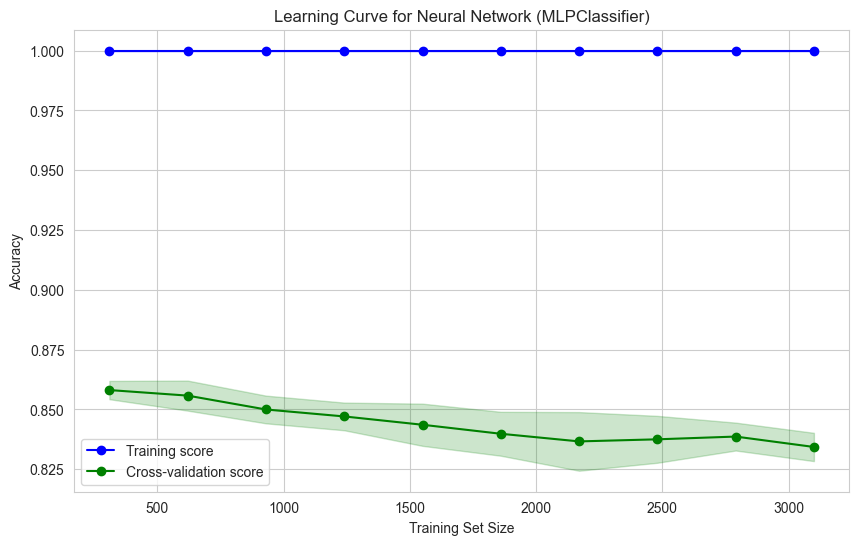

In [81]:

import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold
import numpy as np

# Initialize MLPClassifier (Neural Network)
# You can adjust hidden_layer_sizes, activation, solver, etc., based on your needs
nn = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)

# StratifiedKFold for cross-validation
cv = StratifiedKFold(n_splits=10)
X, y = concatenated_features, feature_train_labels

# Load the dataset (replace with your own dataset)
X = concatenated_features  # Features
y_temp = feature_train_labels  # Target labels
y = matrix2array(y_temp)  # Convert your matrix to an array if needed

# Generate the learning curve data
train_sizes, train_scores, test_scores = learning_curve(
    nn, X, y, cv=cv, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10), scoring='accuracy'
)

# Calculate mean and standard deviation for train and test scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plotting the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label="Training score", color="blue", marker='o')
plt.plot(train_sizes, test_scores_mean, label="Cross-validation score", color="green", marker='o')

# Fill between the mean and std deviation for train/test scores
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, color="blue", alpha=0.2)
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, color="green", alpha=0.2)

plt.title("Learning Curve for Neural Network (MLPClassifier)")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.grid(True)
plt.show()


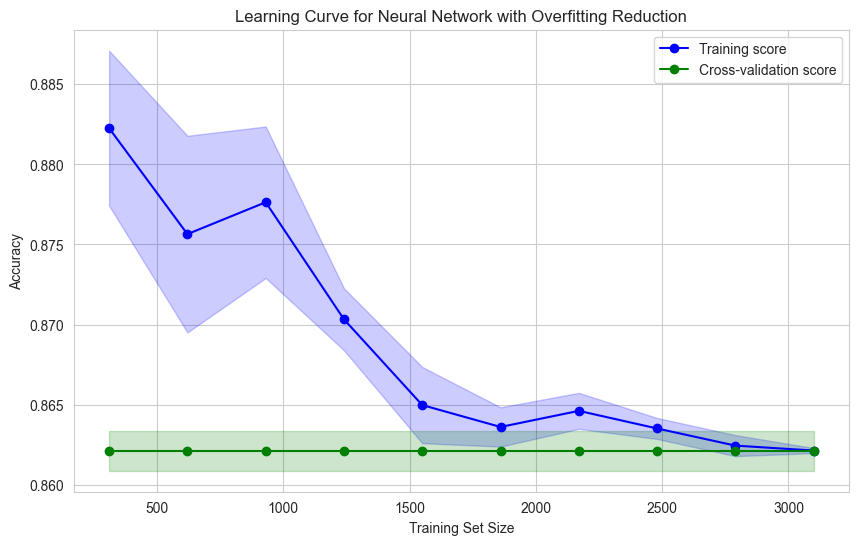

In [83]:
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.model_selection import StratifiedKFold
import numpy as np

# Define the Neural Network model (LVM implementation)
nn = MLPClassifier(
    hidden_layer_sizes=(50, 50),  # Two hidden layers with 50 neurons each
    activation='relu',  # Activation function
    solver='adam',  # Optimizer
    alpha=0.001,  # L2 regularization to reduce overfitting
    max_iter=500,  # Max iterations
    learning_rate='adaptive',  # Learning rate adapts based on progress
    early_stopping=True,  # Stop early if validation score stagnates
    n_iter_no_change=10,  # Stop after 10 iterations without improvement
    random_state=42  # Reproducibility
)

# StratifiedKFold for cross-validation
cv = StratifiedKFold(n_splits=10)

# Features and target labels from concatenated features and training labels
X, y = concatenated_features, feature_train_labels

# Convert y to the proper format if needed
y = matrix2array(y) 

# Generate learning curve data
train_sizes, train_scores, test_scores = learning_curve(
    nn, X, y, cv=cv, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10), scoring='accuracy'
)

# Compute the mean and standard deviation of training and test scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label="Training score", color="blue", marker='o')
plt.plot(train_sizes, test_scores_mean, label="Cross-validation score", color="green", marker='o')

# Fill the areas between mean and std deviation for both curves
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, color="blue", alpha=0.2)
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, color="green", alpha=0.2)

# Add titles and labels
plt.title("Learning Curve for Neural Network with Overfitting Reduction")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.grid(True)

# Show the plot
plt.show()


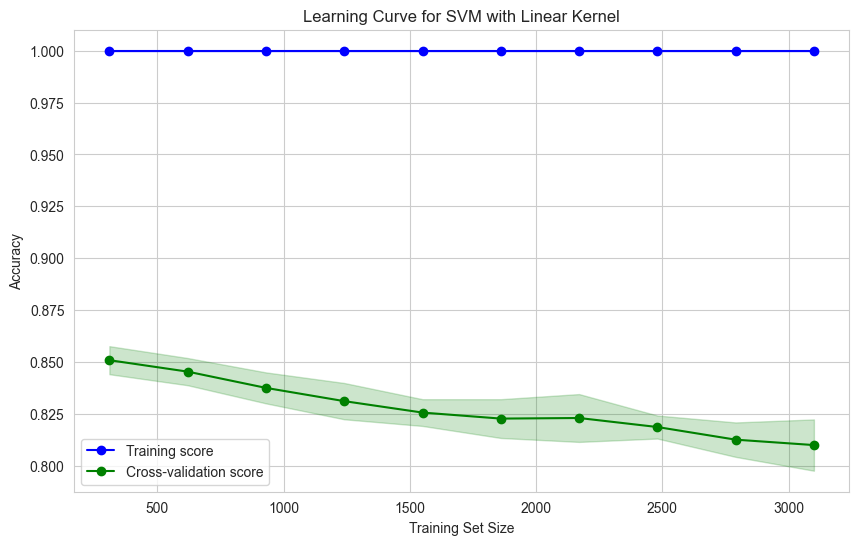

In [84]:
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.model_selection import StratifiedKFold
import numpy as np

# Define the SVM model with a linear kernel
svm = SVC(
    kernel='linear',  # Linear kernel for SVM
    C=1.0,  # Regularization parameter
    random_state=42  # For reproducibility
)

# StratifiedKFold for cross-validation
cv = StratifiedKFold(n_splits=10)

# Features and target labels
X, y = concatenated_features, feature_train_labels

# Convert y to the proper format if needed
y = matrix2array(y)

# Generate the learning curve data
train_sizes, train_scores, test_scores = learning_curve(
    svm, X, y, cv=cv, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10), scoring='accuracy'
)

# Calculate the mean and standard deviation of train and test scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label="Training score", color="blue", marker='o')
plt.plot(train_sizes, test_scores_mean, label="Cross-validation score", color="green", marker='o')

# Fill between the mean and std deviation for train/test scores
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, color="blue", alpha=0.2)
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, color="green", alpha=0.2)

# Add titles and labels
plt.title("Learning Curve for SVM with Linear Kernel")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.grid(True)

# Show the plot
plt.show()


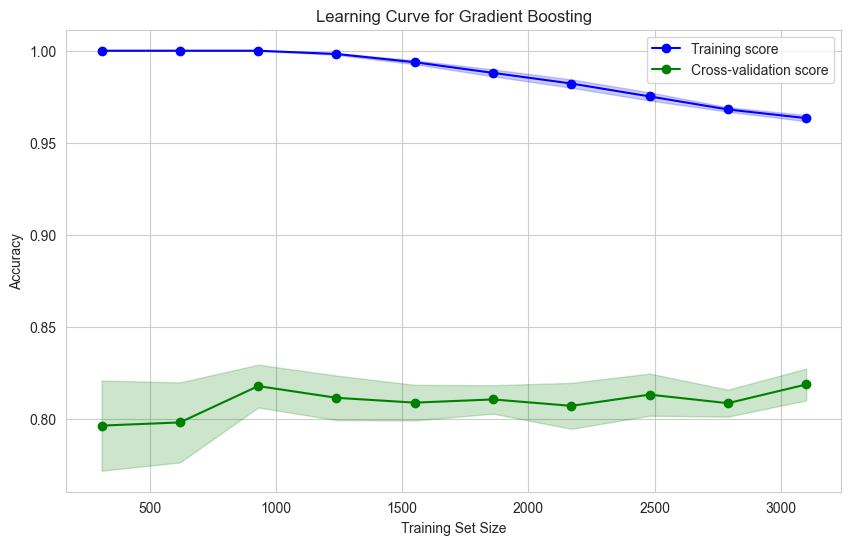

In [85]:
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.model_selection import StratifiedKFold
import numpy as np

# Define the Gradient Boosting model
gb = GradientBoostingClassifier(
    n_estimators=100,  # Number of boosting stages (trees)
    learning_rate=0.1,  # Shrinks the contribution of each tree
    max_depth=3,  # Maximum depth of each tree (weak learner)
    random_state=42  # For reproducibility
)

# StratifiedKFold for cross-validation
cv = StratifiedKFold(n_splits=10)

# Features and target labels
X, y = concatenated_features, feature_train_labels

# Convert y to the proper format if needed
y = matrix2array(y)

# Generate the learning curve data
train_sizes, train_scores, test_scores = learning_curve(
    gb, X, y, cv=cv, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10), scoring='accuracy'
)

# Calculate the mean and standard deviation of train and test scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label="Training score", color="blue", marker='o')
plt.plot(train_sizes, test_scores_mean, label="Cross-validation score", color="green", marker='o')

# Fill between the mean and std deviation for train/test scores
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, color="blue", alpha=0.2)
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, color="green", alpha=0.2)

# Add titles and labels
plt.title("Learning Curve for Gradient Boosting")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.grid(True)

# Show the plot
plt.show()


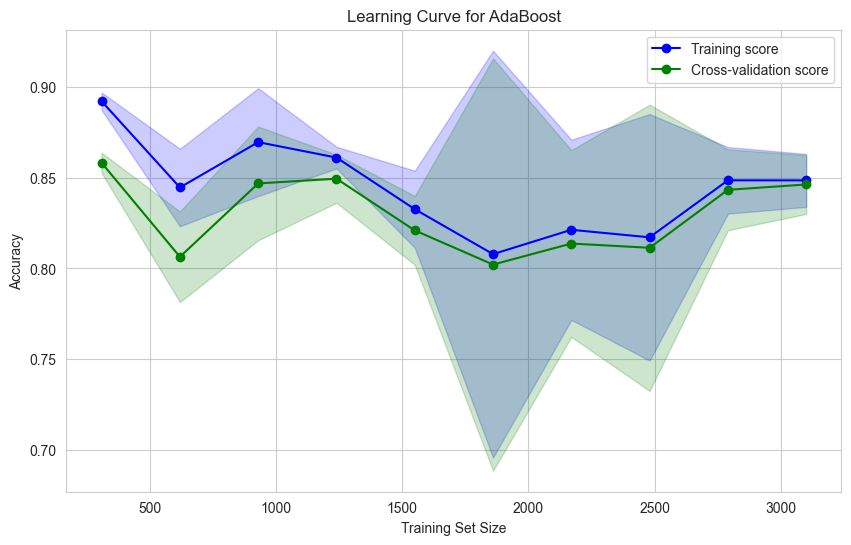

In [86]:
from sklearn.ensemble import AdaBoostClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.model_selection import StratifiedKFold
import numpy as np

# Define the AdaBoost model
ada = AdaBoostClassifier(
    n_estimators=100,  # Number of weak learners (trees)
    learning_rate=1.0,  # Learning rate
    random_state=42  # For reproducibility
)

# StratifiedKFold for cross-validation
cv = StratifiedKFold(n_splits=10)

# Features and target labels
X, y = concatenated_features, feature_train_labels

# Convert y to the proper format if needed
y = matrix2array(y)

# Generate the learning curve data
train_sizes, train_scores, test_scores = learning_curve(
    ada, X, y, cv=cv, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10), scoring='accuracy'
)

# Calculate the mean and standard deviation of train and test scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label="Training score", color="blue", marker='o')
plt.plot(train_sizes, test_scores_mean, label="Cross-validation score", color="green", marker='o')

# Fill between the mean and std deviation for train/test scores
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, color="blue", alpha=0.2)
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, color="green", alpha=0.2)

# Add titles and labels
plt.title("Learning Curve for AdaBoost")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.grid(True)

# Show the plot
plt.show()


In [87]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import numpy as np

# Create a pipeline that includes scaling (SVM performs better with normalized data)
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardize the features
    ('svm', SVC(kernel='linear', random_state=42))  # SVM with linear kernel
])

# Parameter grid to tune 'C'
param_grid = {
    'svm__C': [0.01, 0.1, 1.0, 10.0, 100.0]  # Testing different values for regularization
}

# Use GridSearchCV for hyperparameter tuning with cross-validation
grid_search = GridSearchCV(
    pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1
)

# Fit the model to your data
grid_search.fit(X, y)

# Get the best parameters and model
best_model = grid_search.best_estimator_
print(f"Best C parameter: {grid_search.best_params_['svm__C']}")


Best C parameter: 0.01


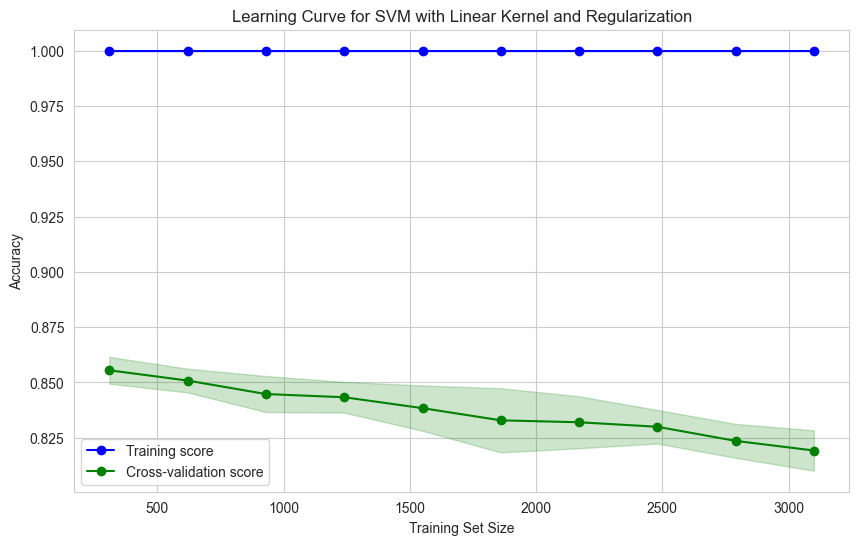

In [88]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
import numpy as np

# Define the SVM model with a linear kernel and a pipeline that includes scaling
svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Feature scaling
    ('svm', SVC(kernel='linear', C=0.1, random_state=42))  # Reduced C for regularization
])

# StratifiedKFold for cross-validation
cv = StratifiedKFold(n_splits=10)

# Features and target labels
X, y = concatenated_features, feature_train_labels

# Convert y to the proper format if needed
y = matrix2array(y)

# Generate the learning curve data
train_sizes, train_scores, test_scores = learning_curve(
    svm_pipeline, X, y, cv=cv, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10), scoring='accuracy'
)

# Calculate the mean and standard deviation of train and test scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label="Training score", color="blue", marker='o')
plt.plot(train_sizes, test_scores_mean, label="Cross-validation score", color="green", marker='o')

# Fill between the mean and std deviation for train/test scores
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, color="blue", alpha=0.2)
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, color="green", alpha=0.2)

# Add titles and labels
plt.title("Learning Curve for SVM with Linear Kernel and Regularization")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.grid(True)

# Show the plot
plt.show()
